In [1]:
import numpy as np

def get_flow_rate(Sw_traj, qt, aw, bw):
    from buckley_leverette_te import BuckleyLeverette
    bl = BuckleyLeverette()
    fw_func = bl.fractional_flow

    nx = bw.shape[0]
    Ne = bw.shape[1]
    
    Nt = qt.shape[0]-1
    Ne = 10

    qwt = []
    qot = []
    swt = []
    fwt = []
    costt = []
    for t in range(Nt):
        Sw_flat = Sw_traj[t,:]
        
        qws = []
        qos = []
        sws = []
        fws = []
        costs = []
        for i in range(Ne):
            Sw = Sw_flat[(i+1)*nx-1]
            _b = bw[-1,i]
            
            fw = fw_func(Sw, aw, _b)
            qw = fw*qt[t]
            qo = (1-fw)*(qt[t])
            
            qws.append(qw.full()[0,0])
            qos.append(qo.full()[0,0])
            sws.append(Sw)
            fws.append(fw)

            cost = bl._stage_cost([Sw], qt[t], aw, _b)*(0.99**(t*0.03))
            
            costs.append(cost)

        qwt.append(qws)
        qot.append(qos)
        swt.append(sws)
        costt.append(costs)
        fwt.append(fws)
        
    fwt = np.array(fwt)
    swt = np.array(swt)
    costt = np.array(costt)

    return qwt, qot, swt, costt[:,:,0,0], fwt

def calculate_cost(Swinit, qseq, aw, bw, Ne, nx):
    """Calculate cost function

    Args:
        Swinit (_type_): Initial Sw, shape (nx, Ne)
        qseq (_type_): Control sequence, shape (Nt)
        aw: a uncertainty, shape (nx, Ne)
        bw: b uncertainty, shape (nx, Ne)
    """
    
    from setup_sbl_te import setup_sbl_ocp, BLParamsSmpcShort, BLParamsTrue
    from buckley_leverette_te import BuckleyLeverette
    bl = BuckleyLeverette()
    fw_func = bl.fractional_flow
    
    params_mpc = BLParamsSmpcShort(N_mpc = 74, 
                                Ne = Ne,
                                nx = nx,
                                bw = bw)
    
    ocp = setup_sbl_ocp(params_mpc, 
                        qmpc=[1.0],
                        qocp=[])
    
    f_discrete = ocp.bl.simulate_at_k

    Sw = Swinit*1
    
    cost_traj = []

    qwt = []
    qot = []
    swt = []
    fwt = []

    for k, q in enumerate(qseq):
        costs = []
        new_Sw = []

        qws = []
        qos = []
        sws = []
        fws = []

        for i in range(Ne):
            _Sw = Sw[i*nx:(i+1)*nx]
            
            Swlast = _Sw[-1]
            _b = bw[-1,i]
            
            fw = fw_func(Swlast, aw, _b)
            qw = fw*q
            qo = (1-fw)*(q)
            
            qws.append(qw.full()[0,0])
            qos.append(qo.full()[0,0])
            sws.append(Sw)
            fws.append(fw)

            
            cost = -bl._stage_cost(_Sw, q, aw, bw[-1,i])*(0.99**(k*0.03))
            costs.append(cost.full()[0,0])
        
            _Sw = f_discrete(_Sw, q, aw, bw[:,i]).full()[:,0]
            new_Sw.extend(_Sw)

        qwt.append(qws)
        qot.append(qos)
        swt.append(sws)
        fwt.append(fws)  
            
        cost_traj.append(costs)
        Sw = np.array(new_Sw)

    qwt = np.array(qwt)
    qot = np.array(qot)
    swt = np.array(swt)
    fwt = np.array(fwt)
        
    return qwt, qot, swt, np.array(cost_traj), fwt 


## plot the uncertainty 

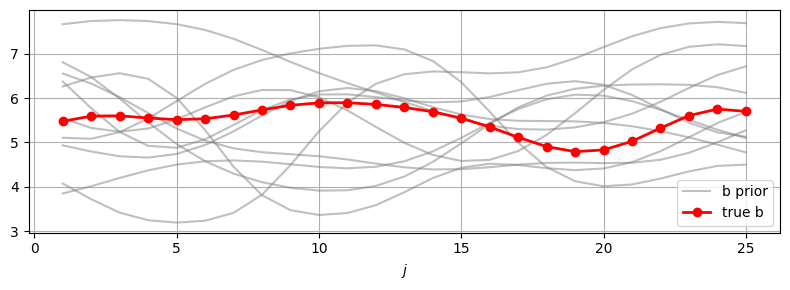

In [2]:
import matplotlib.pyplot as plt
import numpy as np

bw = np.load("./data/p1_bw.npy")
b_true = np.load("./data/b_true.npy")

fig, ax = plt.subplots(1, 1, figsize=(8,3), sharex=True)
xrange = range(1, b_true.shape[0]+1)
ax.plot(xrange, bw, color='gray', alpha=0.5)
ax.plot(xrange, b_true, color='red', linewidth=2, marker="o")
ax.plot([], color='gray', alpha=0.5, label="b prior")
ax.plot([], color='red', linewidth=2, label="true b", marker="o")
ax.legend()
ax.set_xlabel("$j$")
plt.grid()
fig.tight_layout()
plt.savefig("./data/results_prior_ensemble_parameter.png")
plt.show()

## Get all data

In [3]:
# socp_Sw_traj = np.load("./data/socp_Sw_traj.npy")
socp_qt = np.load("./data/p1_seis_socp_qocp.npy")

# wse_Sw_traj = np.load("./data/wse_Sw_traj.npy")
wse_qt = np.load("./data/p1_seis_wse_qmpc.npy")

# nse_Sw_traj = np.load("./data/nse_Sw_traj.npy")
nse_qt = np.load("./data/p1_nse_qmpc.npy")

# nse_cc_Sw_traj = np.load("./data/nse_cc_Sw_traj.npy")
nse_cc_qt = np.load("./data/nse_cc_qmpc.npy")

# notc_5_Sw_traj = np.load("./data/notc_5_Sw_traj.npy")
notc_5_qt = np.load("./data/notc_5_qmpc.npy")

# notc_10_Sw_traj = np.load("./data/notc_10_Sw_traj.npy")
notc_10_qt = np.load("./data/notc_10_qmpc.npy")

# notc_20_Sw_traj = np.load("./data/notc_20_Sw_traj.npy")
notc_20_qt = np.load("./data/notc_20_qmpc.npy")


nx = 25
Swinit = [1.0] + [0.2]*(nx-1)
## true model
aw = 20.0
bw = np.load("./data/b_true.npy")[:,np.newaxis]
Ne = 1

true_socp_qwt, true_socp_qot, true_socp_swt, true_socp_cost, true_socp_fwt = calculate_cost(Swinit, socp_qt, aw, bw, Ne, nx)
true_wse_qwt, true_wse_qot, true_wse_swt, true_wse_cost, true_wse_fwt = calculate_cost(Swinit, wse_qt, aw, bw, Ne, nx)
true_nse_qwt, true_nse_qot, true_nse_swt, true_nse_cost, true_nse_fwt = calculate_cost(Swinit, nse_qt, aw, bw, Ne, nx)
true_nse_cc_qwt, true_nse_cc_qot, true_nse_cc_swt, true_nse_cc_cost, true_nse_cc_fwt = calculate_cost(Swinit, nse_cc_qt, aw, bw, Ne, nx)
true_notc_5_qwt, true_notc_5_qot, true_notc_5_swt, true_notc_5_cost, true_notc_5_fwt = calculate_cost(Swinit, notc_5_qt, aw, bw, Ne, nx)
true_notc_10_qwt, true_notc_10_qot, true_notc_10_swt, true_notc_10_cost, true_notc_10_fwt = calculate_cost(Swinit, notc_10_qt, aw, bw, Ne, nx)
true_notc_20_qwt, true_notc_20_qot, true_notc_20_swt, true_notc_20_cost, true_notc_20_fwt = calculate_cost(Swinit, notc_20_qt, aw, bw, Ne, nx)


bw = np.load("./data/p1_bw.npy")
Ne = 10
SwinitNe = np.array([Swinit]*Ne).flatten()
prior_wse_qwt, prior_wse_qot, prior_wse_swt, prior_wse_cost, prior_wse_fwt = calculate_cost(SwinitNe, wse_qt, aw, bw, Ne, nx)
prior_nse_qwt, prior_nse_qot, prior_nse_swt, prior_nse_cost, prior_nse_fwt = calculate_cost(SwinitNe, nse_qt, aw, bw, Ne, nx)
prior_nse_cc_qwt, prior_nse_cc_qot, prior_nse_cc_swt, prior_nse_cc_cost, prior_nse_cc_fwt = calculate_cost(SwinitNe, nse_cc_qt, aw, bw, Ne, nx)
prior_notc_5_qwt, prior_notc_5_qot, prior_notc_5_swt, prior_notc_5_cost, prior_notc_5_fwt = calculate_cost(SwinitNe, notc_5_qt, aw, bw, Ne, nx)
prior_notc_10_qwt, prior_notc_10_qot, prior_notc_10_swt, prior_notc_10_cost, prior_notc_10_fwt = calculate_cost(SwinitNe, notc_10_qt, aw, bw, Ne, nx)
prior_notc_20_qwt, prior_notc_20_qot, prior_notc_20_swt, prior_notc_20_cost, prior_notc_20_fwt = calculate_cost(SwinitNe, notc_20_qt, aw, bw, Ne, nx)


## plot solutions

There are two parts:
1. Comparison of SMPC without terminal cost for K_mpc = [5, 10, 20]
1. Comparison of SMPC with and without model update

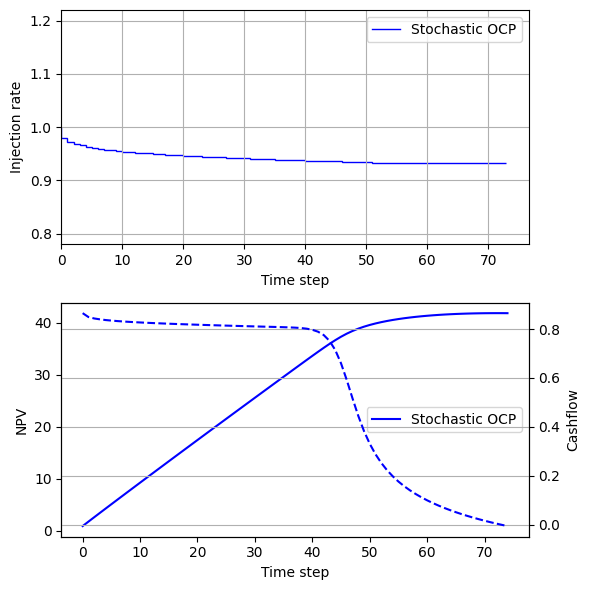

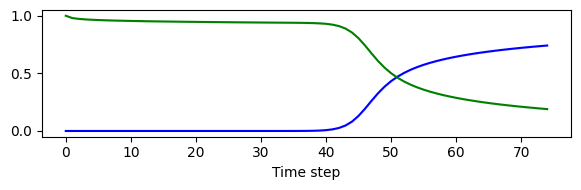

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(6,6))
ax[0].stairs(range(len(socp_qt)-1), socp_qt, label="Stochastic OCP", color="blue", orientation="horizontal", baseline=None)
ax[0].legend()
ax[0].set_ylabel("Injection rate")
ax[0].set_xlabel("Time step")
ax[0].set_ylim([0.78, 1.22])
ax[0].grid(True)
ax[1].plot(np.mean(np.cumsum(true_socp_cost, axis=0), axis=1), color='blue')
ax[1].plot([], color='blue', label="Stochastic OCP")
ax[1].set_ylabel("NPV")
ax[1].set_xlabel("Time step")
ax[1].legend(loc="center right")
ax1 = ax[1].twinx()
ax1.plot(np.mean(true_socp_cost, axis=1), color="blue", linestyle="dashed")
ax1.set_ylabel("Cashflow")
ax1.grid()
fig.tight_layout()
plt.savefig("./data/results_socp_cost.png")
plt.show()

Nt = len(true_socp_cost)
fig, ax = plt.subplots(figsize=(6,2), sharex=True)
ax.plot(np.mean(true_socp_qwt, axis=1), label="water rate", color="blue")
ax.fill_between(range(Nt), np.percentile(true_socp_qwt, 5, axis=1), np.percentile(true_socp_qwt, 95, axis=1),  color="blue", alpha=0.1)
ax.plot(np.mean(true_socp_qot, axis=1), label="oil rate", color="green")
ax.fill_between(range(Nt), np.percentile(true_socp_qot, 5, axis=1), np.percentile(true_socp_qot, 95, axis=1),  color="green", alpha=0.1)

ax.set_xlabel("Time step")
fig.tight_layout()
plt.savefig("./data/results_socp_fluidprofile.png")
plt.show()

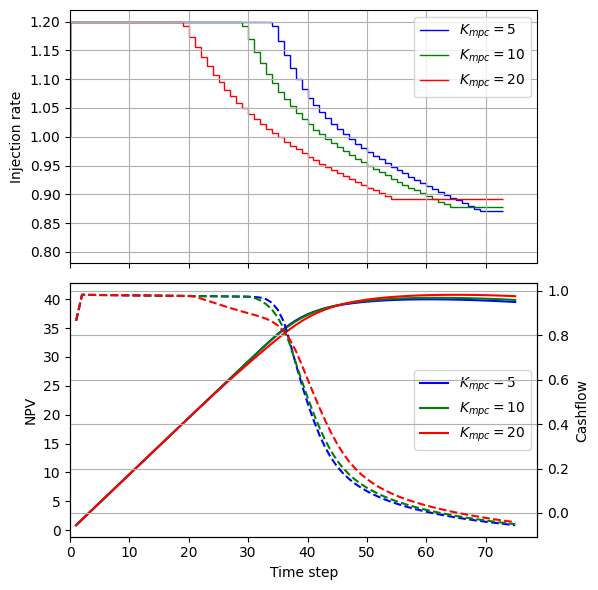

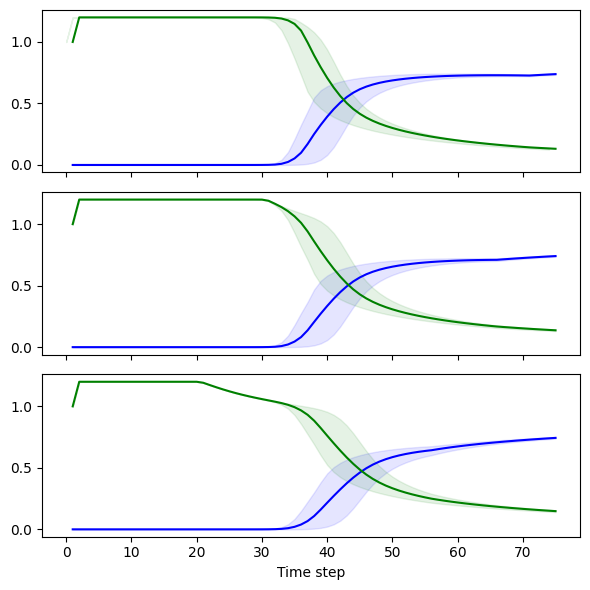

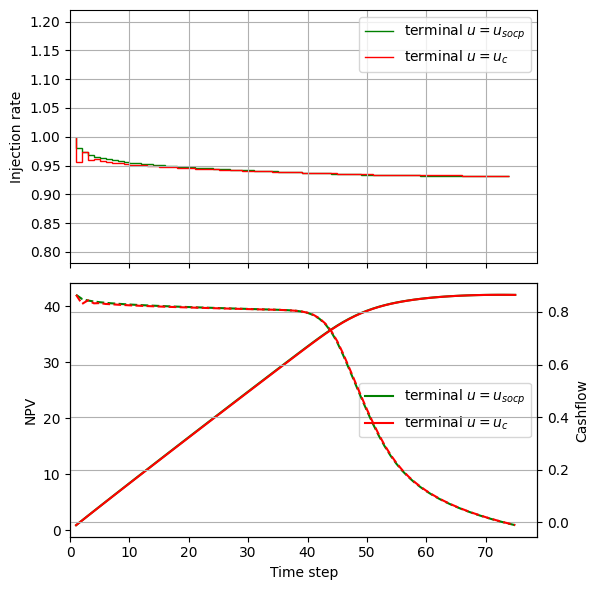

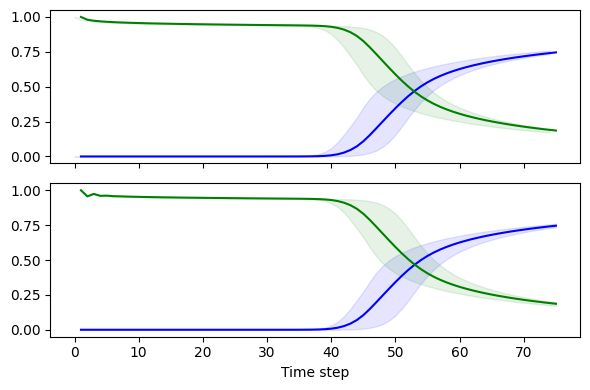

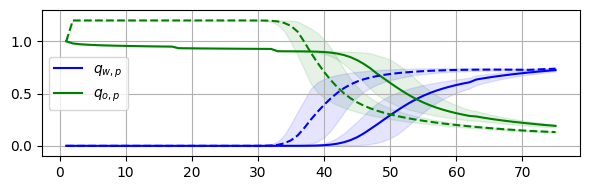

In [5]:
Nt = len(prior_notc_5_cost)

## Comparison of SMPC without terminal cost
fig, ax = plt.subplots(2, 1, figsize=(6,6), sharex=True)
ax[0].stairs(range(len(notc_5_qt)-1), notc_5_qt, label="$K_{mpc} = 5$", color="blue", orientation="horizontal", baseline=None)
ax[0].stairs(range(len(notc_10_qt)-1), notc_10_qt, label="$K_{mpc} = 10$", color="green", orientation="horizontal", baseline=None)
ax[0].stairs(range(len(notc_20_qt)-1), notc_20_qt, label="$K_{mpc} = 20$", color="red", orientation="horizontal", baseline=None)
ax[0].legend()
ax[0].set_ylabel("Injection rate")
ax[0].set_ylim([0.78, 1.22])
ax[0].grid()
ax[1].plot(range(1,Nt+1),np.mean(np.cumsum(prior_notc_5_cost, axis=0), axis=1), color='blue')
ax[1].plot(range(1,Nt+1),np.mean(np.cumsum(prior_notc_10_cost, axis=0), axis=1), color='green')
ax[1].plot(range(1,Nt+1),np.mean(np.cumsum(prior_notc_20_cost, axis=0), axis=1), color='red')
ax[1].plot([], color='blue', label="$K_{mpc} = 5$")
ax[1].plot([], color='green', label="$K_{mpc} = 10$")
ax[1].plot([], color='red', label="$K_{mpc} = 20$")
ax[1].set_ylabel("NPV")
ax[1].set_xlabel("Time step")
ax[1].legend(loc="center right")
ax1 = ax[1].twinx()
ax1.plot(range(1,Nt+1),np.mean(prior_notc_5_cost, axis=1), color="blue", linestyle="dashed")
ax1.plot(range(1,Nt+1),np.mean(prior_notc_10_cost, axis=1), color="green", linestyle="dashed")
ax1.plot(range(1,Nt+1),np.mean(prior_notc_20_cost, axis=1), color="red", linestyle="dashed")
ax1.set_ylabel("Cashflow")
ax1.grid()
fig.tight_layout()
plt.savefig("./data/results_notc_cost.png")


Nt = len(prior_notc_5_qwt)
fig, ax = plt.subplots(3,1,figsize=(6,6), sharex=True)
ax[0].plot(range(1,Nt+1),np.mean(prior_notc_5_qwt, axis=1), label="water rate", color="blue")
ax[0].fill_between(range(1,Nt+1), np.percentile(prior_notc_5_qwt, 5, axis=1), np.percentile(prior_notc_5_qwt, 95, axis=1),  color="blue", alpha=0.1)
ax[0].plot(range(1,Nt+1),np.mean(prior_notc_5_qot, axis=1), label="oil rate", color="green")
ax[0].fill_between(range(Nt), np.percentile(prior_notc_5_qot, 5, axis=1), np.percentile(prior_notc_5_qot, 95, axis=1),  color="green", alpha=0.1)

ax[1].plot(range(1,Nt+1),np.mean(prior_notc_10_qwt, axis=1), label="water rate", color="blue")
ax[1].fill_between(range(1,Nt+1), np.percentile(prior_notc_10_qwt, 5, axis=1), np.percentile(prior_notc_10_qwt, 95, axis=1),  color="blue", alpha=0.1)
ax[1].plot(range(1,Nt+1),np.mean(prior_notc_10_qot, axis=1), label="oil rate", color="green")
ax[1].fill_between(range(1,Nt+1), np.percentile(prior_notc_10_qot, 5, axis=1), np.percentile(prior_notc_10_qot, 95, axis=1),  color="green", alpha=0.1)

ax[2].plot(range(1,Nt+1),np.mean(prior_notc_20_qwt, axis=1), label="water rate", color="blue")
ax[2].fill_between(range(1,Nt+1), np.percentile(prior_notc_20_qwt, 5, axis=1), np.percentile(prior_notc_20_qwt, 95, axis=1),  color="blue", alpha=0.1)
ax[2].plot(range(1,Nt+1),np.mean(prior_notc_20_qot, axis=1), label="oil rate", color="green")
ax[2].fill_between(range(1,Nt+1), np.percentile(prior_notc_20_qot, 5, axis=1), np.percentile(prior_notc_20_qot, 95, axis=1),  color="green", alpha=0.1)
ax[2].set_xlabel("Time step")
fig.tight_layout()
plt.savefig("./data/results_notc_fluidprofile.png")
plt.show()


## Comparison of SMPC with and without model update
fig, ax = plt.subplots(2, 1, figsize=(6,6), sharex=True)
# ax.stairs(range(len(socp_qt)-1), socp_qt, label="Stochastic OCP", color="blue", orientation="horizontal", baseline=None)
ax[0].stairs(range(1,len(nse_qt)), nse_qt, label="terminal $u = u_{socp}$", color="green", orientation="horizontal", baseline=None)
ax[0].stairs(range(1,len(nse_cc_qt)), nse_cc_qt, label="terminal $u = u_c$", color="red", orientation="horizontal", baseline=None)
# ax[0].stairs(range(len(wse_qt)-1), wse_qt, label="With Model Update", color="blue", orientation="horizontal", baseline=None)
ax[0].legend()
ax[0].set_ylabel("Injection rate")
ax[0].set_ylim([0.78, 1.22])
ax[0].grid(True)
ax[1].plot(range(1,Nt+1),np.mean(np.cumsum(prior_nse_cost, axis=0), axis=1), color='green')
ax[1].plot(range(1,Nt+1),np.mean(np.cumsum(prior_nse_cc_cost, axis=0), axis=1), color='red')
# ax[1].plot(range(1,Nt+1),-np.mean(np.cumsum(wse_costt, axis=0), axis=1), color='blue')
# ax.plot([], color='blue', label="Stochastic OCP")
ax[1].plot([], color='green', label="terminal $u = u_{socp}$")
ax[1].plot([], color='red', label="terminal $u = u_c$")
# ax[1].plot([], color='blue', label="With Model Update")
ax[1].set_ylabel("NPV")
ax[1].set_xlabel("Time step")
ax[1].legend(loc="center right")
ax1 = ax[1].twinx()
# ax1.plot(-np.mean(socp_costt, axis=1), color="blue", linestyle="dashed")
ax1.plot(range(1,Nt+1),np.mean(prior_nse_cost, axis=1), color="green", linestyle="dashed")
ax1.plot(range(1,Nt+1),np.mean(prior_nse_cc_cost, axis=1), color="red", linestyle="dashed")
# ax1.plot(range(1,Nt+1),-np.mean(wse_costt, axis=1), colorblue", linestyle="dashed")
ax1.set_ylabel("Cashflow")
ax1.grid()
fig.tight_layout()
plt.savefig("./data/results_tc_cost.png")
plt.show()


fig, ax = plt.subplots(2,1,figsize=(6,4), sharex=True)
ax[0].plot(range(1,Nt+1),np.mean(prior_nse_qwt, axis=1), label="water rate", color="blue")
ax[0].fill_between(range(Nt), np.percentile(prior_nse_qwt, 5, axis=1), np.percentile(prior_nse_qwt, 95, axis=1),  color="blue", alpha=0.1)
ax[0].plot(range(1,Nt+1),np.mean(prior_nse_qot, axis=1), label="oil rate", color="green")
ax[0].fill_between(range(Nt), np.percentile(prior_nse_qot, 5, axis=1), np.percentile(prior_nse_qot, 95, axis=1),  color="green", alpha=0.1)

ax[1].plot(range(1,Nt+1),np.mean(prior_nse_cc_qwt, axis=1), label="water rate", color="blue")
ax[1].fill_between(range(1,Nt+1), np.percentile(prior_nse_cc_qwt, 5, axis=1), np.percentile(prior_nse_cc_qwt, 95, axis=1),  color="blue", alpha=0.1)
ax[1].plot(range(1,Nt+1),np.mean(prior_nse_cc_qot, axis=1), label="oil rate", color="green")
ax[1].fill_between(range(1,Nt+1), np.percentile(prior_nse_cc_qot, 5, axis=1), np.percentile(prior_nse_cc_qot, 95, axis=1),  color="green", alpha=0.1)

ax[1].set_xlabel("Time step")
fig.tight_layout()
plt.savefig("./data/results_tc_fluidprofile.png")
plt.show()

# fluid profile between those without and with temrinal cost. Only for K_mpc = 5 vs with SOCP solution, respectively.
fig, ax = plt.subplots(figsize=(6,2))
ax.plot(range(1,Nt+1), np.mean(prior_wse_qwt, axis=1), label="$q_{w,p}$", color="blue")
ax.fill_between(range(1,Nt+1), np.percentile(prior_wse_qwt, 5, axis=1), np.percentile(prior_wse_qwt, 95, axis=1),  color="blue", alpha=0.1)
ax.plot(range(1,Nt+1), np.mean(prior_wse_qot, axis=1), label="$q_{o,p}$", color="green")
ax.fill_between(range(1,Nt+1), np.percentile(prior_wse_qot, 5, axis=1), np.percentile(prior_wse_qot, 95, axis=1),  color="green", alpha=0.1)

ax.plot(range(1,Nt+1), np.mean(prior_notc_5_qwt, axis=1), color="blue", linestyle="dashed")
ax.fill_between(range(1,Nt+1), np.percentile(prior_notc_5_qwt, 5, axis=1), np.percentile(prior_notc_5_qwt, 95, axis=1),  color="blue", alpha=0.1)
ax.plot(range(1,Nt+1), np.mean(prior_notc_5_qot, axis=1), color="green", linestyle="dashed")
ax.fill_between(range(1,Nt+1), np.percentile(prior_notc_5_qot, 5, axis=1), np.percentile(prior_notc_5_qot, 95, axis=1),  color="green", alpha=0.1)
ax.set_ylim(-0.1, 1.3)
fig.tight_layout()
plt.legend()
plt.grid(True)
plt.savefig("./data/results_rate_comparison.png")

## Evaluate on the true model

In [6]:
def cumulative(cost):
    return np.cumsum(cost, axis=0)

cost_list = [(true_notc_5_cost, prior_notc_5_cost),
             (true_notc_10_cost, prior_notc_10_cost),
             (true_notc_20_cost, prior_notc_20_cost),
             (true_nse_cc_cost, prior_nse_cc_cost), 
             (true_nse_cost, prior_nse_cost),
             (true_wse_cost, prior_wse_cost)]

print(f"Case & True NPV & Expected NPV & SD NPV \\\\\\hline")
for i, cost in enumerate(cost_list):
    print(f"Case {i+1} & {cumulative(cost[0])[-1,0]:.6g} & {np.mean(cumulative(cost[1])[-1]):.6g} & {np.std(cumulative(cost[1])[-1]):.6g} \\\\")
    

Case & True NPV & Expected NPV & SD NPV \\\hline
Case 1 & 39.4182 & 39.5267 & 2.32714 \\
Case 2 & 39.7572 & 39.8743 & 2.32461 \\
Case 3 & 40.4012 & 40.5327 & 2.31607 \\
Case 4 & 41.8588 & 42.0278 & 2.27355 \\
Case 5 & 41.8572 & 42.0257 & 2.2743 \\
Case 6 & 41.8707 & 42.0453 & 2.25777 \\


## control and fluid profile plot between the true and prior 

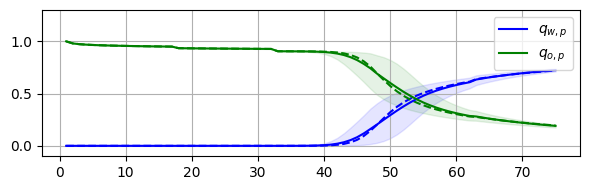

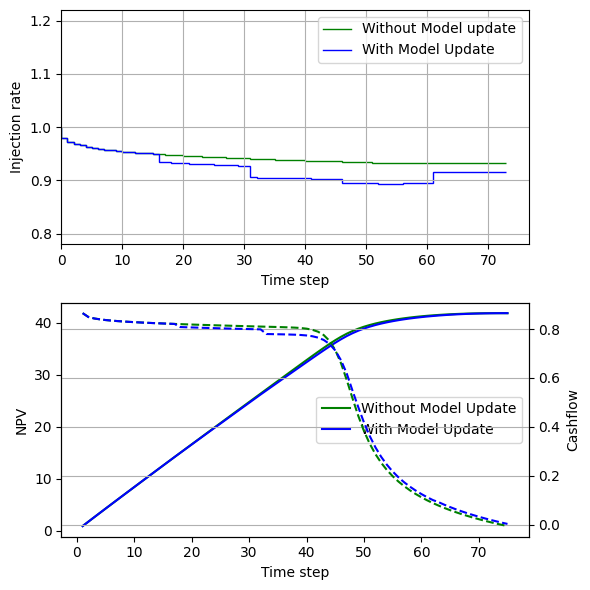

41.870722887463145 41.85722818013559


In [7]:

Nt = len(prior_wse_qwt)
fig, ax = plt.subplots(figsize=(6,2))

ax.plot(range(1,Nt+1), np.mean(true_wse_qwt, axis=1), color="blue", linestyle="dashed")
ax.plot(range(1,Nt+1), np.mean(true_wse_qot, axis=1), color="green", linestyle="dashed")
ax.plot(range(1,Nt+1), np.mean(prior_wse_qwt, axis=1), color="blue", label="$q_{w,p}$")
ax.fill_between(range(1,Nt+1), np.percentile(prior_wse_qwt, 5, axis=1), np.percentile(prior_wse_qwt, 95, axis=1),  color="blue", alpha=0.1)
ax.plot(range(1,Nt+1), np.mean(prior_wse_qot, axis=1), color="green", label="$q_{o,p}$")
ax.fill_between(range(1,Nt+1), np.percentile(prior_wse_qot, 5, axis=1), np.percentile(prior_wse_qot, 95, axis=1),  color="green", alpha=0.1)

ax.set_ylim(-0.1, 1.3)
# ax.plot(range(1,Nt+1), np.mean(prior_nse_qwt, axis=1), color="blue", label="$q_{w,p}$")
# ax.fill_between(range(1,Nt+1), np.percentile(prior_nse_qwt, 5, axis=1), np.percentile(prior_nse_qwt, 95, axis=1),  color="blue", alpha=0.1)
# ax.plot(range(1,Nt+1), np.mean(prior_nse_qot, axis=1), color="green", label="$q_{o,p}$")
# ax.fill_between(range(1,Nt+1), np.percentile(prior_nse_qot, 5, axis=1), np.percentile(prior_nse_qot, 95, axis=1),  color="green", alpha=0.1)
fig.tight_layout()
plt.legend()
plt.grid(True)
plt.savefig("./data/results_rate_comparison_prior_vs_true.png")

## Comparison of SMPC with and without model update
Nt = len(nse_qt)
fig, ax = plt.subplots(2, 1, figsize=(6,6))
# ax.stairs(range(len(socp_qt)-1), socp_qt, label="Stochastic OCP", color="blue", orientation="horizontal", baseline=None)
ax[0].stairs(range(len(nse_qt)-1), nse_qt, label="Without Model update", color="green", orientation="horizontal", baseline=None)
ax[0].stairs(range(len(wse_qt)-1), wse_qt, label="With Model Update", color="blue", orientation="horizontal", baseline=None)
ax[0].legend()
ax[0].set_ylabel("Injection rate")
ax[0].set_xlabel("Time step")
ax[0].set_ylim([0.78, 1.22])
ax[0].grid(True)
ax[1].plot(range(1,Nt+1),np.mean(np.cumsum(true_nse_cost, axis=0), axis=1), color='green')
ax[1].plot(range(1,Nt+1),np.mean(np.cumsum(true_wse_cost, axis=0), axis=1), color='blue')
# ax.plot([], color='blue', label="Stochastic OCP")
ax[1].plot([], color='green', label="Without Model Update")
ax[1].plot([], color='blue', label="With Model Update")
ax[1].set_ylabel("NPV")
ax[1].set_xlabel("Time step")
ax[1].legend(loc="center right")
ax1 = ax[1].twinx()
# ax1.plot(-np.mean(socp_costt, axis=1), color="blue", linestyle="dashed")
ax1.plot(range(1,Nt+1),np.mean(true_nse_cost, axis=1), color="green", linestyle="dashed")
ax1.plot(range(1,Nt+1),np.mean(true_wse_cost, axis=1), color="blue", linestyle="dashed")
ax1.set_ylabel("Cashflow")
ax1.grid()
fig.tight_layout()
plt.savefig("./data/results_wse_vs_nse_profile.png")
plt.show()

print(np.mean(np.cumsum(true_wse_cost, axis=0), axis=1)[-1], np.mean(np.cumsum(true_nse_cost, axis=0), axis=1)[-1])

# Section 4.2 Run simulation with several initial ensembles

<Figure size 800x600 with 0 Axes>

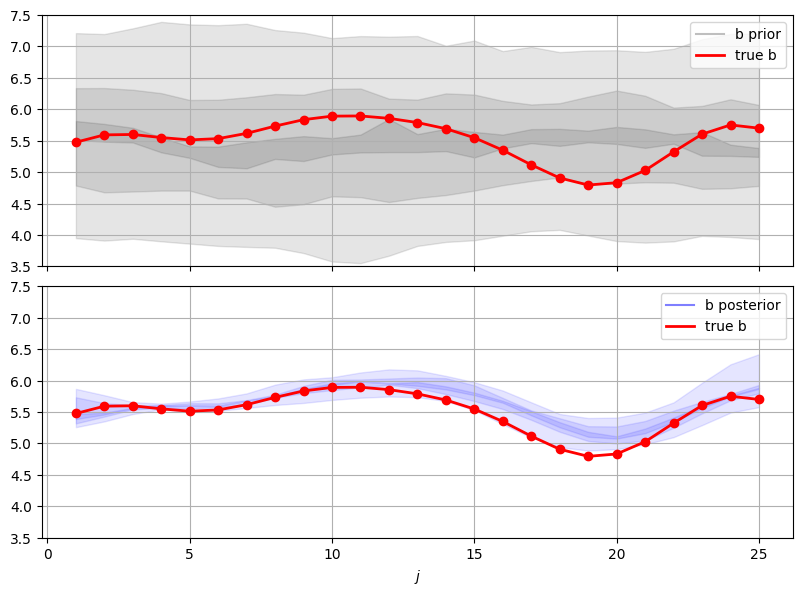

In [8]:
bw_traj = np.load("./data/bad_wse_bw_traj.npy")
bw = np.load("./data/bw_bad.npy")
b_true = np.load("./data/b_true.npy")


def plot_prior_vs_post_param(bw_traj, bw, b_true, suffix):

    xrange = range(1, bw.shape[0]+1)
    post_bw5 = np.percentile(bw_traj[-1], 5, axis=1)
    post_bw95 = np.percentile(bw_traj[-1], 95, axis=1)
    post_bw25 = np.percentile(bw_traj[-1], 25, axis=1)
    post_bw75 = np.percentile(bw_traj[-1], 75, axis=1)
    post_bw45 = np.percentile(bw_traj[-1], 45, axis=1)
    post_bw55 = np.percentile(bw_traj[-1], 55, axis=1)

    prior_bw5 = np.percentile(bw, 5, axis=1)
    prior_bw95 = np.percentile(bw, 95, axis=1)
    prior_bw25 = np.percentile(bw, 25, axis=1)
    prior_bw75 = np.percentile(bw, 75, axis=1)
    prior_bw45 = np.percentile(bw, 45, axis=1)
    prior_bw55 = np.percentile(bw, 55, axis=1)
    fig, ax = plt.subplots(2, 1, figsize=(8,6), sharex=True)
    # ax.plot(bw, color='gray', alpha=0.5)
    # ax.plot(bw_traj[-1], color='blue', alpha=0.5)

    ax[0].fill_between(xrange, prior_bw5, prior_bw95, color="black", alpha=0.1)
    ax[0].fill_between(xrange, prior_bw25, prior_bw75, color="black", alpha=0.1)
    ax[0].fill_between(xrange, prior_bw45, prior_bw55, color="black", alpha=0.1)
    ax[1].fill_between(xrange, post_bw5, post_bw95, color="blue", alpha=0.1)
    ax[1].fill_between(xrange, post_bw25, post_bw75, color="blue", alpha=0.1)
    ax[1].fill_between(xrange, post_bw45, post_bw55, color="blue", alpha=0.1)


    ax[0].plot(xrange, b_true, color='red', linewidth=2, marker="o")
    ax[1].plot(xrange, b_true, color='red', linewidth=2, marker="o")
    ax[0].plot([], color='gray', alpha=0.5, label="b prior")
    ax[1].plot([], color='blue', alpha=0.5, label="b posterior")
    ax[0].plot([], color='red', linewidth=2, label="true b")
    ax[1].plot([], color='red', linewidth=2, label="true b")

    ax[0].set_ylim(3.5, 7.5)
    ax[1].set_ylim(3.5, 7.5)

    ax[0].legend()
    ax[1].legend()
    ax[0].grid(True)
    ax[1].grid(True)
    ax[1].set_xlabel("$j$")
    fig.tight_layout()
    plt.savefig(f"./data/results_{suffix}_prior_post_bw.png")
    plt.show()

# bw_traj = np.load("./data/wse_bw_traj.npy")
# bw = np.load("./data/bw.npy")
# b_true = np.load("./data/b_true.npy")
# plot_prior_vs_post_param(bw_traj, bw, b_true, suffix="")

# bw_traj = np.load("./data/bad_wse_bw_traj.npy")
# bw = np.load("./data/bw_bad.npy")
# b_true = np.load("./data/b_true.npy")
# plot_prior_vs_post_param(bw_traj, bw, b_true, suffix="bad")

# plot percentiles
# for i in range(10):
#     bw_traj = np.load(f"./data/p{i}_seis_wse_bw_traj.npy")
#     bw = np.load(f"./data/p{i}_bw.npy")
#     b_true = np.load("./data/b_true.npy")
#     plot_prior_vs_post_param(bw_traj, bw, b_true, suffix=f"p{i}_seis")
    
# plot violin
Npert = 10
plt.figure(figsize=(8,6))
# bw_trajs = []
# bws = []
# # for i in range(10):
# #     bw_traj = np.load(f"./data/p{i}_wse_bw_traj.npy")[-1,:,:]
# #     bw = np.load(f"./data/p{i}_bw.npy")
# #     b_true = np.load("./data/b_true.npy")
    
# #     bw_trajs.append(bw_traj)
# #     bws.append(bw)
    
bw_trajs = np.concatenate([np.load(f"./data/p{i}_seis_wse_bw_traj.npy") for i in range(1,Npert)], axis=0)
bws = np.concatenate([np.load(f"./data/p{i}_bw.npy") for i in range(1,Npert)], axis=1)
b_true = np.load("./data/b_true.npy")


plot_prior_vs_post_param(bw_trajs, bws, b_true, suffix=f"pall_seis")

# plt.figure(figsize=(8,4))
# nx = 25
# positions = [i for i in range(1,nx+1)]
# positions1 = [i-0.2 for i in range(1,nx+1)]
# positions2 = [i+0.2 for i in range(1,nx+1)]

# plt.boxplot(bws, positions=positions2)
# plt.boxplot(bw_trajs, positions=positions1)

# plt.plot(positions, b_true, color="red", marker="o")
# # plt.grid()

# plt.hist([bws.flatten(), bw_trajs.flatten(), b_true.flatten()], density=True, color=["grey", "green", "red"])
# plt.tight_layout()

In [9]:
bw_trajs.shape

(36, 25, 10)

In [ ]:
print(f"Case & With model update & No model update \\\\\\hline")

data = {}
data["true"] = {}
data["prior"] = {}
data["post"] = {}
Npert = 10
for i in range(0,Npert):
    
    data["true"][f"p{i}"] = {}
    data["true"][f"p{i}"]["socp"] = {}
    data["true"][f"p{i}"]["wse"] = {}
    data["true"][f"p{i}"]["nse"] = {}

    socp_qt = np.load(f"./data/p{i}_seis_socp_qocp.npy")
    wse_qt = np.load(f"./data/p{i}_seis_wse_qmpc.npy")
    nse_qt = np.load(f"./data/p{i}_nse_qmpc.npy")
    
    nx = 25
    Swinit = [1.0] + [0.2]*(nx-1)
    ## true model
    aw = 20.0
    bw = np.load("./data/b_true.npy")[:,np.newaxis]
    
    data["true"][f"p{i}"]["bw"] = bw
    
    Ne = 1

    # plt.plot(bw, color="red")

    # data["true"][f"p{i}"]["socp"]["qwt"], data["true"][f"p{i}"]["socp"]["qot"], data["true"][f"p{i}"]["socp"]["swt"], data["true"][f"p{i}"]["socp"]["cost"], data["true"][f"p{i}"]["socp"]["fwt"] = calculate_cost(Swinit, socp_qt, aw, bw, Ne, nx)
    data["true"][f"p{i}"]["wse"]["qwt"], data["true"][f"p{i}"]["wse"]["qot"], data["true"][f"p{i}"]["wse"]["swt"], data["true"][f"p{i}"]["wse"]["cost"], data["true"][f"p{i}"]["wse"]["fwt"] = calculate_cost(Swinit, wse_qt, aw, bw, Ne, nx)
    data["true"][f"p{i}"]["nse"]["qwt"], data["true"][f"p{i}"]["nse"]["qot"], data["true"][f"p{i}"]["nse"]["swt"], data["true"][f"p{i}"]["nse"]["cost"], data["true"][f"p{i}"]["nse"]["fwt"] = calculate_cost(Swinit, nse_qt, aw, bw, Ne, nx)
    # true_nse_qwt, true_nse_qot, true_nse_swt, true_nse_cost, true_nse_fwt = calculate_cost(Swinit, nse_qt, aw, bw, Ne, nx)

    data["prior"][f"p{i}"] = {}
    data["prior"][f"p{i}"]["socp"] = {}
    data["prior"][f"p{i}"]["wse"] = {}
    data["prior"][f"p{i}"]["nse"] = {}
    

    nx = 25
    Ne = 10
    Swinit = [1.0] + [0.2]*(nx-1)
    SwinitNe = np.array([Swinit]*Ne).flatten()
    ## true model
    aw = 20.0
    bw = np.load(f"./data/p{i}_bw.npy")

    data["prior"][f"p{i}"]["bw"] = bw
    
    # data["prior"][f"p{i}"]["socp"]["qwt"], data["prior"][f"p{i}"]["socp"]["qot"], data["prior"][f"p{i}"]["socp"]["swt"], data["prior"][f"p{i}"]["socp"]["cost"], data["prior"][f"p{i}"]["socp"]["fwt"] = calculate_cost(SwinitNe, socp_qt, aw, bw, Ne, nx)
    data["prior"][f"p{i}"]["wse"]["qwt"], data["prior"][f"p{i}"]["wse"]["qot"], data["prior"][f"p{i}"]["wse"]["swt"], data["prior"][f"p{i}"]["wse"]["cost"], data["prior"][f"p{i}"]["wse"]["fwt"] = calculate_cost(SwinitNe, wse_qt, aw, bw, Ne, nx)
    data["prior"][f"p{i}"]["nse"]["qwt"], data["prior"][f"p{i}"]["nse"]["qot"], data["prior"][f"p{i}"]["nse"]["swt"], data["prior"][f"p{i}"]["nse"]["cost"], data["prior"][f"p{i}"]["nse"]["fwt"] = calculate_cost(SwinitNe, nse_qt, aw, bw, Ne, nx)

    data["post"][f"p{i}"] = {}
    data["post"][f"p{i}"]["socp"] = {}
    data["post"][f"p{i}"]["wse"] = {}
    data["post"][f"p{i}"]["nse"] = {}

    nx = 25
    Ne = 10
    Swinit = [1.0] + [0.2]*(nx-1)
    SwinitNe = np.array([Swinit]*Ne).flatten()
    ## true model
    aw = 20.0
    bw = np.load(f"./data/p{i}_wse_bw_traj.npy")[-1,:,:]

    data["post"][f"p{i}"]["bw"] = bw
    
    # data["prior"][f"p{i}"]["socp"]["qwt"], data["prior"][f"p{i}"]["socp"]["qot"], data["prior"][f"p{i}"]["socp"]["swt"], data["prior"][f"p{i}"]["socp"]["cost"], data["prior"][f"p{i}"]["socp"]["fwt"] = calculate_cost(SwinitNe, socp_qt, aw, bw, Ne, nx)
    data["post"][f"p{i}"]["wse"]["qwt"], data["post"][f"p{i}"]["wse"]["qot"], data["post"][f"p{i}"]["wse"]["swt"], data["post"][f"p{i}"]["wse"]["cost"], data["post"][f"p{i}"]["wse"]["fwt"] = calculate_cost(SwinitNe, wse_qt, aw, bw, Ne, nx)
    data["post"][f"p{i}"]["nse"]["qwt"], data["post"][f"p{i}"]["nse"]["qot"], data["post"][f"p{i}"]["nse"]["swt"], data["post"][f"p{i}"]["nse"]["cost"], data["post"][f"p{i}"]["nse"]["fwt"] = calculate_cost(SwinitNe, nse_qt, aw, bw, Ne, nx)

    print(f'Case 6-{i+1} {cumulative(data["true"][f"p{i}"]["nse"]["cost"])[-1,0]:.6g}', end="")
    print(f' & {np.mean(cumulative(data["prior"][f"p{i}"]["nse"]["cost"])[-1]):.6g} & {np.std(cumulative(data["prior"][f"p{i}"]["nse"]["cost"])[-1]):.6g}', end="")
    
    
    print(f' & {cumulative(data["true"][f"p{i}"]["wse"]["cost"])[-1,0]:.6g}', end="")
    print(f' & {np.mean(cumulative(data["post"][f"p{i}"]["wse"]["cost"])[-1]):.6g} & {np.std(cumulative(data["post"][f"p{i}"]["nse"]["cost"])[-1]):.6g} \\\\')


Case & With model update & No model update \\\hline
Case 6-1 41.8615 & 41.9249 & 2.72352 & 41.8698 & 41.8788 & 0.561857 \\
Case 6-2 41.8572 & 42.0257 & 2.2743 & 41.8707 & 41.9621 & 0.51464 \\
Case 6-3 41.8764 & 42.3241 & 2.59983 & 41.8737 & 42.0818 & 0.649079 \\
Case 6-4 41.8731 & 41.8608 & 2.80432 & 41.8731 & 41.7916 & 0.482214 \\
Case 6-5 41.8491 & 42.1446 & 2.2159 & 41.8641 & 42.2568 & 0.542677 \\
Case 6-6 41.8491 & 42.5095 & 2.58139 & 41.8585 & 42.2581 & 0.434079 \\
Case 6-7 41.8763 & 42.0014 & 1.86742 & 41.873 & 41.9613 & 0.486401 \\
Case 6-8 41.8459 & 41.0967 & 2.83186 & 41.8528 & 41.9797 & 0.46882 \\
Case 6-9 41.874 & 41.5915 & 2.10802 & 41.8738 & 42.2524 & 0.572924 \\
Case 6-10 41.852 & 42.1074 & 3.30682 & 41.8573 & 42.3281 & 0.425477 \\


In [27]:
bw.shape

(25, 10)

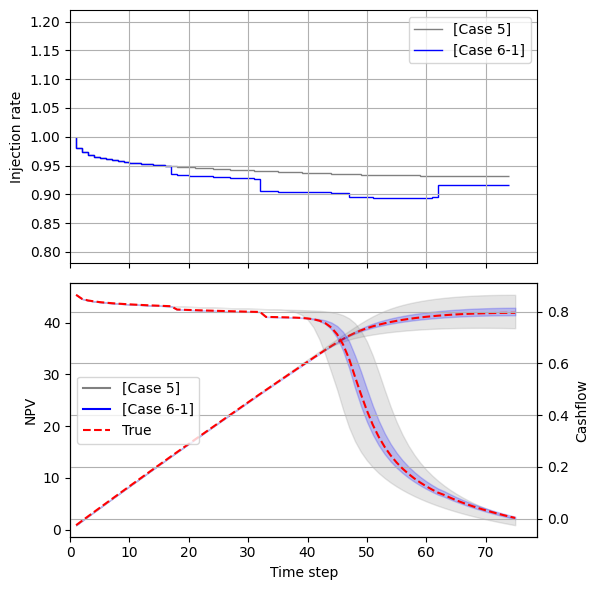

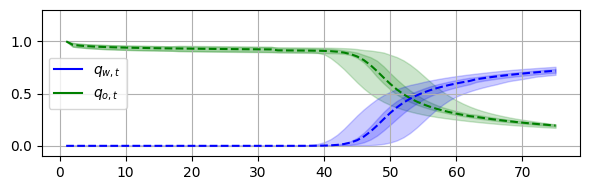

In [15]:
Npert = 10



# Plot control
fig1, ax = plt.subplots(2, 1, figsize=(6,6), sharex=True)

ax1 = ax[0]
ax2 = ax[1]

# socp_qt_all = np.array([np.load(f"./data/p{i}_seis_socp_qocp.npy") for i in range(0,Npert)]).T
wse_qt_all = np.array([np.load(f"./data/p{i}_seis_wse_qmpc.npy") for i in range(0,Npert)]).T
nse_qt_all = np.array([np.load(f"./data/p{i}_nse_qmpc.npy") for i in range(0,Npert)]).T

true_socp_qt = np.load(f"./data/true_socp_qocp.npy")

xrange = range(1,true_socp_qt.shape[0]+1)
xrange_stairs = range(1,true_socp_qt.shape[0])
# ax1.plot(socp_qt, color="grey")
# for i in range(Ne):
#     ax1.stairs(xrange_stairs, wse_qt_all[:,i], color="blue", orientation="horizontal", baseline=None)
#     ax1.stairs(xrange_stairs, nse_qt_all[:,i], color="grey", orientation="horizontal", baseline=None)
ax1.stairs(xrange_stairs, nse_qt_all[:,1], color="grey", alpha=1.0, orientation="horizontal", baseline=None, label="[Case 5]")
ax1.stairs(xrange_stairs, wse_qt_all[:,1], color="blue", alpha=1.0, orientation="horizontal", baseline=None, label="[Case 6-1]")
# ax1.stairs(xrange_stairs, np.mean(nse_qt_all, axis=1), color="grey", alpha=1.0, orientation="horizontal", baseline=None)
# ax1.stairs(xrange_stairs, np.mean(wse_qt_all, axis=1), color="blue", alpha=1.0, orientation="horizontal", baseline=None)
# ax1.fill_between(xrange, np.percentile(nse_qt_all, 5, axis=1), np.percentile(nse_qt_all, 95, axis=1), color="grey", alpha=0.2)
# ax1.fill_between(xrange, np.percentile(wse_qt_all, 5, axis=1), np.percentile(wse_qt_all, 95, axis=1), color="blue", alpha=0.2)
# ax1.set_ylim(0.85, 1.05)    
ax1.set_ylim(0.78, 1.22)
ax1.grid()
# ax1.set_xlabel("Time step")
ax1.legend()
ax1.set_ylabel("Injection rate")


prior_cost_all = np.concatenate([data["prior"][f"p{i}"]["nse"]["cost"] for i in range(1,2)], axis=1)
post_cost_all = np.concatenate([data["post"][f"p{i}"]["wse"]["cost"] for i in range(1,2)], axis=1)
true_cost_all = np.concatenate([data["true"][f"p{i}"]["wse"]["cost"] for i in range(1,2)], axis=1)

prior_cum_all = np.cumsum(prior_cost_all, axis=0)
post_cum_all = np.cumsum(post_cost_all, axis=0)
true_cum_all = np.cumsum(true_cost_all, axis=0)

ax2.fill_between(xrange, np.percentile(prior_cum_all, 5, axis=1), np.percentile(prior_cum_all, 95, axis=1), color="grey", alpha=0.2)
ax2.fill_between(xrange, np.percentile(post_cum_all, 5, axis=1), np.percentile(post_cum_all, 95, axis=1), color="blue", alpha=0.2)
ax2.plot(xrange, np.mean(true_cum_all, axis=1), color="red", linestyle="dashed")
ax2.set_ylabel("NPV")
ax21 = ax2.twinx()
ax21.fill_between(xrange, np.percentile(prior_cost_all, 5, axis=1), np.percentile(prior_cost_all, 95, axis=1), color="grey", alpha=0.2)
ax21.fill_between(xrange, np.percentile(post_cost_all, 5, axis=1), np.percentile(post_cost_all, 95, axis=1), color="blue", alpha=0.2)
ax21.plot([], color="grey", alpha=1.0, label="[Case 5]")
ax21.plot([], color="blue", alpha=1.0, label="[Case 6-1]")
ax21.plot(xrange, np.mean(true_cost_all, axis=1), color="red", linestyle="dashed", label="True")
ax21.set_ylabel("Cashflow")
ax21.grid()
ax21.legend(loc="center left")

ax2.set_xlabel("Time step")


fig1.tight_layout()


plt.savefig("./data/results_p1_control.png")

# Plot rate profile
fig3, ax3 = plt.subplots(figsize=(6,2))

prior_qot_all = np.concatenate([data["prior"][f"p{i}"]["nse"]["qot"] for i in range(0,Npert)], axis=1)
post_qot_all = np.concatenate([data["post"][f"p{i}"]["wse"]["qot"] for i in range(0,Npert)], axis=1)
true_qot_all = np.concatenate([data["true"][f"p{i}"]["wse"]["qot"] for i in range(0,Npert)], axis=1)


ax3.fill_between(xrange, np.percentile(prior_qot_all, 5, axis=1), np.percentile(prior_qot_all, 95, axis=1), color="green", alpha=0.2)
ax3.fill_between(xrange, np.percentile(post_qot_all, 5, axis=1), np.percentile(post_qot_all, 95, axis=1), color="green", alpha=0.2)
ax3.plot(xrange, np.mean(true_qot_all, axis=1), color="green", linestyle="dashed")

prior_qwt_all = np.concatenate([data["prior"][f"p{i}"]["nse"]["qwt"] for i in range(0,Npert)], axis=1)
post_qwt_all = np.concatenate([data["post"][f"p{i}"]["wse"]["qwt"] for i in range(0,Npert)], axis=1)
true_qwt_all = np.concatenate([data["true"][f"p{i}"]["wse"]["qwt"] for i in range(0,Npert)], axis=1)

xrange = range(1,prior_qot_all.shape[0]+1)
ax3.fill_between(xrange, np.percentile(prior_qwt_all, 5, axis=1), np.percentile(prior_qwt_all, 95, axis=1), color="blue", alpha=0.2)
ax3.fill_between(xrange, np.percentile(post_qwt_all, 5, axis=1), np.percentile(post_qwt_all, 95, axis=1), color="blue", alpha=0.2)
ax3.plot(xrange, np.mean(true_qwt_all, axis=1), color="blue", linestyle="dashed")
    
    
ax3.plot([], color="blue", label="$q_{w,t}$")
ax3.plot([], color="green", label="$q_{o,t}$")
ax3.legend(loc="center left")


ax3.set_ylim(-0.1, 1.3)
ax3.grid()
fig3.tight_layout()
plt.savefig("./data/results_rate_comparison_all_vs_true.png")

In [16]:
# bw_traj = np.load("./data/p2_seis_wse_bw_traj.npy")
# bw = np.load("./data/p2_bw.npy")
# b_true = np.load("./data/b_true.npy")
# plot_prior_vs_post_param(bw_traj, bw, b_true, suffix="p2_seis")

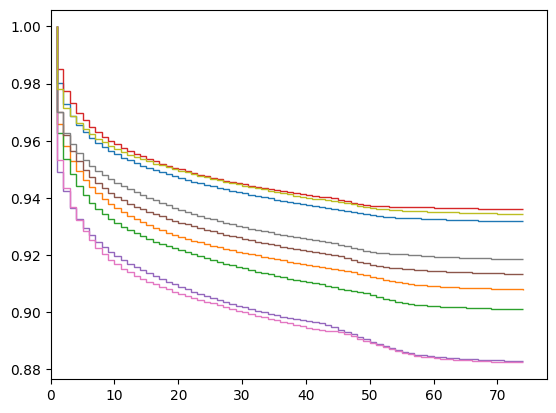

In [18]:
plt.figure()
for kk in range(1,10):
    nse_qt = np.load(f"./data/p{kk}_nse_qmpc.npy")
    # nse_qt = np.load("./data/p1_seis_nse_qmpc.npy")
    
    n = range(1, len(nse_qt))
    plt.stairs(n, nse_qt, orientation="horizontal", baseline=None)

In [22]:
bw_traj = np.load("./data/bad_wse_bw_traj.npy")
bw = np.load("./data/bad_bw.npy")
b_true = np.load("./data/b_true.npy")
plot_prior_vs_post_param(bw_traj, bw, b_true, suffix="bad_seis")

IndexError: index -1 is out of bounds for axis 0 with size 0

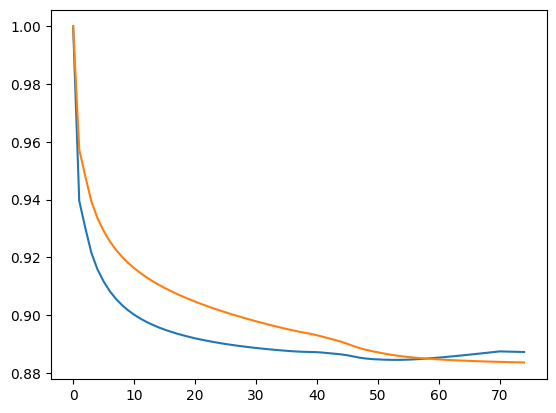

In [25]:
_q1 = np.load("./data/bad_wse_qmpc.npy")
_q2 = np.load("./data/bad_socp_qocp.npy")

plt.plot(_q1)
plt.plot(_q2)